# OpenClassrooms - Ingenieur IA
# Projet 9 - My Content - Partie 2 : Modélisation et évaluation
# Réalisez une application mobile de recommandation de contenu

## Objectif du projet : 
- **Réalisez une application mobile de recommandation de contenu**

## Plan :
- **Partie 1 : Analyse et préparation des données**
    - Chargement des données
    - Analyse Exploratoire des Données
    - Nettoyage des données
    - Séparation des données
    - Sauvegarde des données préparées
     
    
- **Partie 2 : Modélisation et évaluation**
    - Baseline recommandation
        - Modèle basé sur la popularité des articles
    - Content Based recommandation
        - Modèle basé sur la catégorie des articles
        - Modèle basé sur la similarité entre les articles
    - Collaborative Filtering recommandation
        - Model based
            - ALS Model
            - BPR Model
            - LMF Model
        - Memory based
            - Nearest Neighbours with Cosine Recommender Model
    - Récapitulatif et choix du meilleur modèle
    
    
- **Partie 3 : Préparation au déploiement**
    - Récupération du Workpsace Azure
    - Identifications des éléments
    - Enregistrement des données nécessaires au déploiement dans Azure

## Remarque préliminaire :
- **Le code est découpé en fonctions, ce qui permet une meilleure lisibilité et une meilleure maintenabilité du code**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import pickle

import implicit

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Partie 2 : Modélisation et évaluation

## Chargement des données préparées

In [2]:
df_data = pd.read_csv('bookshelf_dataset.csv')
df_data_train = pd.read_csv('bookshelf_dataset_train.csv')
df_data_test = pd.read_csv('bookshelf_dataset_test.csv')

##### Pour les systèmes de recommandation, il y a 2 types de 'ratings' :
- Ratings **explicites** : les utilisateurs mettent des notes aux items en fonction de leur satisfaction (note sur 5 par exemple)
- Ratings **implicites** : on utilise les interactions des utilisateurs avec les items (nombre de clicks par exemple)
> Ces ratings permettent de voir quels sont les items appréciés des utilisateurs et ainsi de dégager leur profil. Ce profil sera utilisé pour leur recommander d'autres articles
> **Dans notre projet, nous avons à faire à des rationgs implicites : ce sont les interations des utilisateurs avec les articles**

## Baseline recommandation

### Modèle basé sur la popularité des articles
- Ce premier modèle recommande les articles les plus populaires non déjà lus par l'utilisateur
- Ce modèle ne dépend pas du profil de l'utilisateur
- Ce premier modèle simple nous servira de **référence**
- Il pourrait également être utilisé dans les cas de Cold Start quand on ne dispose de pas assez d'informations pour faire une recommandation personnalisée à l'utilisateur

#### Get all articles already read for a user

In [3]:
def get_articles_already_read_for_user(user_id):
    articles_already_read = df_data_train[df_data_train['user_id']==user_id]['article_id'].unique().tolist()
    return articles_already_read

#### Get most popular articles

In [4]:
def get_most_popular_articles():
    most_popular_articles = df_data_train['article_id'].value_counts().index.to_list()
    return most_popular_articles

#### Get n recommandations based on articles popularity

In [5]:
def get_recommendations_articles_popularity(user_id, top_n):
    most_popular_articles = get_most_popular_articles()
    articles_already_read_for_user = get_articles_already_read_for_user(user_id)
    most_popular_articles_not_already_read = [i for i in most_popular_articles if i not in set(articles_already_read_for_user)]
    top_n_most_popular_articles_not_already_read = most_popular_articles_not_already_read[:top_n]
    
    return top_n_most_popular_articles_not_already_read

In [6]:
%%time
get_recommendations_articles_popularity(1, 5)

Wall time: 77 ms


[160974, 272143, 123909, 162655, 64329]

### Evaluation
- **Métrique dédiée** au projet :
    - Les métriques classiques de type accuracy, recall ou précision ne sont pas adaptées aux problèmes de recommandations et en particulier à notre projet
    - Nous avons donc implémenté notre propre métrique dédiée à notre problématique ***(voir fichier Excel explicatif)*** :
        - 1 - sur les n recommandations faites à partir des données du jeu d'entrainement, on compte avec combien l'utilisateur a interagi dans le jeu de test (nombre d'interactions des articles recommandés dans le jeu de test)
        - 2 - afin de tenir compte du nombre d'articles effectivement lus par l'utilisateur, on corrige en divisant le nombre d'interactions par le nombre d'articles lus par l'utilisateur dans le jeu de test (s'il n'y a aucun article lu par l'utilisateur, la correction est adaptée pour éviter une division par 0)
        - 3 - on normalise la mesure en divisant le résultat obtenu par le nombre d'utilisateurs de l'évaluation
        - 4 - on multiplie par un coefficient pour avoir un résultat plus lisible
> **La métrique dédiée correspond donc au nombre d'interactions avec les articles recommandés de l'utilisateur dans le jeu de test, corrigé par le nombre d'articles lus dans le jeu de test et normalisé par le nombre d'utilisateurs**

In [7]:
nb_recommandations = 5
nb_users = 10000

#### Get all articles read for a user in test set

In [8]:
def get_articles_read_for_user_in_test_set(user_id):
    articles_read_test_set = df_data_test[df_data_test['user_id']==user_id]['article_id'].unique().tolist() #.values()
    return articles_read_test_set

#### Get number of articles read for a user in test set

In [9]:
def get_nb_articles_read_for_user_in_test_set(user_id):
    nb_articles_read_for_user_in_test_set = len(get_articles_read_for_user_in_test_set(user_id))
    return nb_articles_read_for_user_in_test_set

#### Fonction permettant de faire l'évaluation pour tous les modèles de la famille Content Based
- Implémente la **métrique dédiée**

In [10]:
def evaluation_recommendations_content_based_models(nb_recommandations, nb_users, get_recommendations_content_based, cosine_similarities_matrix=None):
    if nb_users<=0:
        print("Nb users shall be > 0")
    else:
        unique_users_id = df_data_train['user_id'].unique().tolist()
        nb_interactions_total = 0
        metric_total = 0
        i=0
        for user_id in unique_users_id:
            if i==nb_users:
                break
                
            if cosine_similarities_matrix is None:
                recommandations = get_recommendations_content_based(user_id, nb_recommandations)
            else:
                recommandations = get_recommendations_content_based(user_id, nb_recommandations, cosine_similarities_matrix)
            
            articles_read_for_user_in_test_set = get_articles_read_for_user_in_test_set(user_id)
            nb_interactions_for_user = sum(x in articles_read_for_user_in_test_set for x in recommandations)
            nb_interactions_total += nb_interactions_for_user
            
            nb_articles_read_for_user_in_test_set = get_nb_articles_read_for_user_in_test_set(user_id)
            
            if nb_articles_read_for_user_in_test_set == 0 :
                metric_for_user = nb_interactions_for_user / ((nb_articles_read_for_user_in_test_set + 1) * 2)
            else :
                metric_for_user = nb_interactions_for_user / nb_articles_read_for_user_in_test_set
            
            metric_total += metric_for_user
            i+=1
            
        metric_normalized = metric_total / nb_users * 10000
        
        return nb_interactions_total, metric_normalized

In [11]:
nb_interactions_baseline_popularity, metric_baseline_popularity = evaluation_recommendations_content_based_models(nb_recommandations, nb_users, get_recommendations_articles_popularity)

In [12]:
print(f"Evaluation Metric = {metric_baseline_popularity:.2f}")

Evaluation Metric = 0.55


## Content Based recommandation

##### Pour ce type de recommandation, les recommandations faites sont basées sur (i) les interactions utilisateurs-articles et (ii) la similarité entre les contenus :
- On détermine tout d'abord un profil utilisateur => on détermine les items aimés par l'utilisateur (c'est à dire les items avec lesquels il a intéragi)
- On détermine les items similaires => on utilise pour cela une mesure de similarité
- On recommande à l'utilisateur les items similaires à ceux qu'il aime (à son profil)

### Modèle basé sur la catégorie des articles 
- Profil des utilisateurs : basé sur la catégorie préférée
- Similarité : basée sur la similarité des catégories des articles 

In [13]:
df_data_train

,user_id,click_timestamp,click_country,click_region,article_id,category_id,words_count,click_datetime
0,59,1506826800026,1,21,234853,375,140,2017-10-01 03:00:00.026
1,154,1506826804207,1,25,96663,209,206,2017-10-01 03:00:04.207
2,111,1506826814140,1,9,202436,327,333,2017-10-01 03:00:14.140
3,133,1506826823065,1,13,284847,412,266,2017-10-01 03:00:23.065
4,59,1506826830026,1,21,234995,375,155,2017-10-01 03:00:30.026
...,...,...,...,...,...,...,...,...
1033991,119210,1507506684388,1,20,233658,375,149,2017-10-08 23:51:24.388
1033992,235646,1507506685571,1,25,129434,252,168,2017-10-08 23:51:25.571
1033993,2504,1507506686115,1,25,202632,327,189,2017-10-08 23:51:26.115
1033994,25029,1507506686811,1,25,272202,399,206,2017-10-08 23:51:26.811


In [14]:
print(f"Nombre d'utilisateurs dans le jeu d'entrainement : {df_data_train['user_id'].nunique()}")

Nombre d'utilisateurs dans le jeu d'entrainement : 82231


In [15]:
print(f"Nombre d'articles lus dans le jeu d'entrainement : {df_data_train['article_id'].nunique()}")

Nombre d'articles lus dans le jeu d'entrainement : 17710


#### Get most popular category for a user

In [16]:
def get_most_popular_category_for_user(user_id):
    most_popular_category_for_user = df_data_train[df_data_train['user_id']==user_id].groupby(['category_id']).size().sort_values(ascending=False).index[0]
    return most_popular_category_for_user

#### Get most popular articles for a category

In [17]:
def get_most_popular_articles_for_category(category_id):
    most_popular_articles_for_category = df_data_train[df_data_train['category_id']==category_id].groupby(['article_id']).size().sort_values(ascending=False).index.to_list()
    return most_popular_articles_for_category

#### Get n recommandations for a user based on articles category

In [18]:
def get_recommendations_articles_category(user_id, top_n):
    if user_id in df_data_train['user_id'].values:
        most_popular_category_for_user = get_most_popular_category_for_user(user_id)
        most_popular_articles_for_category = get_most_popular_articles_for_category(most_popular_category_for_user)
        articles_already_read_for_user = get_articles_already_read_for_user(user_id)    
        most_popular_articles_for_category_not_already_read = [i for i in most_popular_articles_for_category if i not in set(articles_already_read_for_user)]
        top_n_most_popular_articles_for_category_not_already_read = most_popular_articles_for_category_not_already_read[:top_n]
        return top_n_most_popular_articles_for_category_not_already_read
    else:
        print("Error : User does not exist or user with not enough historic")

In [19]:
%%time
get_recommendations_articles_category(1, 5)

Wall time: 48 ms


[160974, 162655, 158536, 156560, 160417]

### Evaluation

In [20]:
nb_interactions_cb_category, metric_cb_category = evaluation_recommendations_content_based_models(nb_recommandations, nb_users, get_recommendations_articles_category)

In [21]:
print(f"Evaluation Metric = {metric_cb_category:.2f}")

Evaluation Metric = 5.00


### Modèle basé sur la similarité entre les articles 
- Profil des utilisateurs : basé sur le dernier article lu
- Similarité : basée sur la similarité des embeddings des articles (similarité cosinus sur les embeddings) 

#### Construction matrice embeddings articles lus

In [22]:
matrix_articles_embeddings = pd.read_pickle('../../data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle')

In [23]:
matrix_articles_embeddings.shape

(364047, 250)

In [24]:
ids_article_read = df_data_train['article_id'].unique()

In [25]:
ids_article_read.sort()

In [26]:
ids_article_read

array([    27,     81,    137, ..., 364014, 364017, 364043], dtype=int64)

In [27]:
ids_article_read = ids_article_read.tolist()

In [28]:
len(ids_article_read)

17710

In [29]:
matrix_articles_read_embeddings = np.zeros(shape=(len(ids_article_read), matrix_articles_embeddings.shape[1]), dtype='float32')
for i, j in enumerate(ids_article_read):    
    matrix_articles_read_embeddings[i] = matrix_articles_embeddings[j]

In [30]:
matrix_articles_read_embeddings

array([[-0.7008142 , -0.9659266 , -0.1818693 , ..., -0.38887644,
         0.6968653 , -0.5328732 ],
       [ 0.2215637 , -0.97880304,  0.6145965 , ..., -0.24820906,
         0.7173663 , -0.8169451 ],
       [-0.17764656, -0.9692499 ,  0.4397025 , ..., -0.6503148 ,
         0.73871505, -0.9394058 ],
       ...,
       [ 0.69512177, -0.9768214 ,  0.52648866, ...,  0.5662906 ,
        -0.05684129,  0.5272194 ],
       [ 0.29026955, -0.96339834, -0.01913572, ...,  0.61537707,
         0.04842116, -0.30961972],
       [-0.13693178, -0.9954715 ,  0.99129796, ...,  0.9892977 ,
        -0.7615948 , -0.41465205]], dtype=float32)

In [31]:
matrix_articles_read_embeddings.shape

(17710, 250)

#### Get cosine similarities matrix for articles

In [32]:
def get_articles_cosine_similarities_matrix(matrix_articles_embeddings):
    cosine_similarities_matrix = cosine_similarity(matrix_articles_embeddings, matrix_articles_embeddings)
    return cosine_similarities_matrix

In [33]:
cosine_similarities_matrix = get_articles_cosine_similarities_matrix(matrix_articles_read_embeddings)

In [34]:
cosine_similarities_matrix

array([[ 0.99999964,  0.66986096,  0.6915096 , ..., -0.06418734,
         0.07249391,  0.07056355],
       [ 0.66986096,  1.0000001 ,  0.8870426 , ...,  0.10915044,
         0.17474371,  0.03925371],
       [ 0.6915096 ,  0.8870426 ,  0.9999998 , ...,  0.02380319,
         0.11487039, -0.00353779],
       ...,
       [-0.06418734,  0.10915044,  0.02380319, ...,  0.9999999 ,
         0.523187  ,  0.09992522],
       [ 0.07249391,  0.17474371,  0.11487039, ...,  0.523187  ,
         1.0000001 ,  0.37486896],
       [ 0.07056355,  0.03925371, -0.00353779, ...,  0.09992522,
         0.37486896,  1.0000001 ]], dtype=float32)

In [35]:
cosine_similarities_matrix.shape

(17710, 17710)

#### Get similar articles of an existing article

In [36]:
def get_similar_articles(cos_sim_matrix, article_id):
    
    ids = []
    scores = []
    article_index_id = ids_article_read.index(article_id)
    for i in range(len(cos_sim_matrix)):
        ids.append(ids_article_read[i])
        scores.append(cos_sim_matrix[i][article_index_id])

    df_ids_scores = pd.DataFrame(list(zip(ids, scores)), columns=['id', 'score'])    
    df_ids_scores_sorted = df_ids_scores.sort_values(by=['score'], axis=0, ascending=False)
    similar_articles = df_ids_scores_sorted['id'].to_list()
    
    return similar_articles

#### Get last article read for a user

In [37]:
def get_last_article_read(user_id):
    last_article_id = int(df_data_train[df_data_train['user_id']==user_id]['article_id'].iloc[-1])
    return last_article_id

#### Get n recommandations for a user based on articles similarities

In [38]:
def get_recommendations_articles_similarities(user_id, top_n, matrix_cos_sim):
    if user_id in df_data_train['user_id'].values:
        last_article_id = get_last_article_read(user_id)
        similar_articles = get_similar_articles(matrix_cos_sim, last_article_id)
        articles_already_read_for_user = get_articles_already_read_for_user(user_id)
        similar_articles_not_already_read = [i for i in similar_articles if i not in set(articles_already_read_for_user)]
        top_n_similar_articles_not_already_read = similar_articles_not_already_read[:top_n]
        
        return top_n_similar_articles_not_already_read
    else:
        print("Error : User does not exist or user with not enough historic")

In [39]:
%%time
get_recommendations_articles_similarities(1, 5, cosine_similarities_matrix)

Wall time: 85 ms


[283391, 282964, 283971, 283041, 285461]

### Evaluation

In [40]:
nb_interactions_cb_similarity, metric_cb_similarity = evaluation_recommendations_content_based_models(nb_recommandations, nb_users, get_recommendations_articles_similarities, cosine_similarities_matrix=cosine_similarities_matrix)

In [41]:
print(f"Evaluation Metric = {metric_cb_similarity:.2f}")

Evaluation Metric = 2.57


## Collaborative Filtering recommandation

##### Pour ce type de recommandation, les recommandations faites sont basées sur (i) les interactions utilisateurs-articles et (ii) la similarité entre les utilisateurs. Il y a 2 familles :
- Recommandations **'Model based'**
- Recommandations **'Memory based'**

### Utilisation de la librairie Implicit
- Nous avons utilisé pour implémenter ces modèles la librairie **Implicit**
- C'est une librairie spécialisée pour les Dataset avec des ratings implicites comme c'est le cas pour notre projet

### Préparation des données

In [42]:
df_data_train

,user_id,click_timestamp,click_country,click_region,article_id,category_id,words_count,click_datetime
0,59,1506826800026,1,21,234853,375,140,2017-10-01 03:00:00.026
1,154,1506826804207,1,25,96663,209,206,2017-10-01 03:00:04.207
2,111,1506826814140,1,9,202436,327,333,2017-10-01 03:00:14.140
3,133,1506826823065,1,13,284847,412,266,2017-10-01 03:00:23.065
4,59,1506826830026,1,21,234995,375,155,2017-10-01 03:00:30.026
...,...,...,...,...,...,...,...,...
1033991,119210,1507506684388,1,20,233658,375,149,2017-10-08 23:51:24.388
1033992,235646,1507506685571,1,25,129434,252,168,2017-10-08 23:51:25.571
1033993,2504,1507506686115,1,25,202632,327,189,2017-10-08 23:51:26.115
1033994,25029,1507506686811,1,25,272202,399,206,2017-10-08 23:51:26.811


In [43]:
df_data_train_implicit = df_data_train[['user_id', 'article_id']]
df_data_train_implicit

,user_id,article_id
0,59,234853
1,154,96663
2,111,202436
3,133,284847
4,59,234995
...,...,...
1033991,119210,233658
1033992,235646,129434
1033993,2504,202632
1033994,25029,272202


In [44]:
df_data_train_implicit = df_data_train_implicit.groupby(['user_id','article_id']).size().reset_index(name='nb_interactions')
df_data_train_implicit

,user_id,article_id,nb_interactions
0,1,59758,1
1,1,96663,1
2,1,156723,1
3,1,160474,1
4,1,205973,1
...,...,...,...
1015242,235671,233658,1
1015243,235671,286350,1
1015244,235714,68924,1
1015245,235744,129434,1


In [45]:
df_data_train_implicit['nb_interactions'].sum()

1033996

In [46]:
df_data_train_implicit['user_id'] = df_data_train_implicit['user_id'].astype("category")
df_data_train_implicit['article_id'] = df_data_train_implicit['article_id'].astype("category")
df_data_train_implicit['user_num'] = df_data_train_implicit['user_id'].cat.codes
df_data_train_implicit['article_num'] = df_data_train_implicit['article_id'].cat.codes

In [47]:
df_data_train_implicit

,user_id,article_id,nb_interactions,user_num,article_num
0,1,59758,1,0,3011
1,1,96663,1,0,5314
2,1,156723,1,0,8205
3,1,160474,1,0,8500
4,1,205973,1,0,10651
...,...,...,...,...,...
1015242,235671,233658,1,82228,11927
1015243,235671,286350,1,82228,14631
1015244,235714,68924,1,82229,3660
1015245,235744,129434,1,82230,7152


In [48]:
df_data_train_implicit['user_num'].min()

0

In [49]:
df_data_train_implicit['user_num'].max()

82230

In [50]:
df_data_train_implicit['article_num'].min()

0

In [51]:
df_data_train_implicit['article_num'].max()

17709

#### Sparse Matrix articles-users

In [52]:
articles_users_sparse = csr_matrix((df_data_train_implicit['nb_interactions'].astype(float), (df_data_train_implicit['article_num'], df_data_train_implicit['user_num'])))

In [53]:
articles_users_sparse

<17710x82231 sparse matrix of type '<class 'numpy.float64'>'
	with 1015247 stored elements in Compressed Sparse Row format>

#### Sparse Matrix users-articles

In [54]:
users_articles_sparse = articles_users_sparse.T.tocsr()

In [55]:
users_articles_sparse

<82231x17710 sparse matrix of type '<class 'numpy.float64'>'
	with 1015247 stored elements in Compressed Sparse Row format>

### Model based
- Ce sont des modèles basés sur des algorithmes de Machine Learning
- Ils utilisent principalement des techniques de décomposition de Matrices
- La décomposition de matrice permet de réduire la dimension du problème en trouvant les facteurs latents

### Alternating Least Squares Model
- Modèle de recommandation cherchant les facteurs latents en minimisant une fonction de coût des moindres carrés de façon alternative (alternance utilisateurs-facteurs et items-facteurs)

In [56]:
als_model = implicit.als.AlternatingLeastSquares(random_state=1)

In [57]:
als_model.fit(articles_users_sparse)

  0%|          | 0/15 [00:00<?, ?it/s]

In [58]:
recommendations_als = als_model.recommend(1, users_articles_sparse, filter_already_liked_items=True)

In [59]:
recommendations_als

[(11385, 0.35568604),
 (12491, 0.16098791),
 (12286, 0.1293987),
 (11906, 0.12364444),
 (7563, 0.119724736),
 (8384, 0.10810758),
 (8386, 0.09711843),
 (1440, 0.09500466),
 (10800, 0.094821334),
 (8142, 0.09190612)]

In [60]:
articles = []
scores = []

for item in recommendations_als:
    idx, score = item
    articles.append(df_data_train_implicit['article_id'].loc[df_data_train_implicit['article_num'] == idx].iloc[0])
    scores.append(score)

df_recommendations_als = pd.DataFrame({'id article': articles, 'score': scores})

print("Recommandations : ")
print(df_recommendations_als)

Recommandations : 
   id article     score
0      220466  0.355686
1      240233  0.160988
2      236613  0.129399
3      233478  0.123644
4      140720  0.119725
5      158906  0.108108
6      158915  0.097118
7       32750  0.095005
8      207391  0.094821
9      156025  0.091906


#### Get n recommandations for a user based on ALS Model

In [61]:
def get_recommendations_als_model(user_num, top_n):
    if user_num in range(users_articles_sparse.shape[0]):
        recommendations = als_model.recommend(user_num, users_articles_sparse, N=top_n, filter_already_liked_items=True)
        
        articles_recommended = []
        for item in recommendations:
            idx, _ = item
            articles_recommended.append(df_data_train_implicit['article_id'].loc[df_data_train_implicit['article_num'] == idx].iloc[0])
        
        return articles_recommended
    else:
        print("Error : User num does not exist")

In [62]:
%%time
get_recommendations_als_model(1, 5)

Wall time: 20 ms


[220466, 240233, 236613, 233478, 140720]

#### Evaluation

#### Fonction permettant de faire l'évaluation pour tous les modèles de la famille Content Based
- Implémente la **métrique dédiée**

In [63]:
def evaluation_recommendations_implicit_model(nb_recommandations, nb_users, get_recommendations_implicit_model):
    if nb_users==0:
        print("Nb users shall be > 0")
    else:
        nb_interactions_total = 0
        metric_total = 0
        for i in range(min(nb_users, users_articles_sparse.shape[0])):
            recommandations = get_recommendations_implicit_model(i, nb_recommandations)
            user_id = df_data_train_implicit['user_id'].loc[df_data_train_implicit['user_num'] == i].iloc[0]
            articles_read_for_user_in_test_set = get_articles_read_for_user_in_test_set(user_id)
            nb_interactions_for_user = sum(x in articles_read_for_user_in_test_set for x in recommandations)
            nb_interactions_total += nb_interactions_for_user
            
            nb_articles_read_for_user_in_test_set = get_nb_articles_read_for_user_in_test_set(user_id)
            
            if nb_articles_read_for_user_in_test_set == 0 :
                metric_for_user = nb_interactions_for_user / ((nb_articles_read_for_user_in_test_set + 1) * 2)
            else :
                metric_for_user = nb_interactions_for_user / nb_articles_read_for_user_in_test_set
            
            metric_total += metric_for_user
        
        metric_normalized = metric_total / nb_users * 10000
        
        return nb_interactions_total, metric_normalized

In [64]:
nb_interactions_cf_als, metric_cf_als = evaluation_recommendations_implicit_model(nb_recommandations, nb_users, get_recommendations_als_model)

In [65]:
print(f"Evaluation Metric = {metric_cf_als:.2f}")

Evaluation Metric = 3.97


### Bayesian Personalized Ranking Model
- Modèle de recommandation basé sur une analyse Bayésienne du problème et consistant à optimiser l'estimateur du maximum à posteriori

In [66]:
bpr_model = implicit.bpr.BayesianPersonalizedRanking(random_state=1)

In [67]:
bpr_model.fit(articles_users_sparse)

  0%|          | 0/100 [00:00<?, ?it/s]

#### Get n recommandations for a user based on BPR Model

In [68]:
def get_recommendations_bpr_model(user_num, top_n):
    if user_num in range(users_articles_sparse.shape[0]):
        recommendations = bpr_model.recommend(user_num, users_articles_sparse, N=top_n, filter_already_liked_items=True)
        
        articles_recommended = []
        for item in recommendations:
            idx, _ = item
            articles_recommended.append(df_data_train_implicit['article_id'].loc[df_data_train_implicit['article_num'] == idx].iloc[0])
        
        return articles_recommended
    else:
        print("Error : User num does not exist")

In [69]:
%%time
get_recommendations_bpr_model(1, 5)

Wall time: 22 ms


[237209, 220466, 237356, 233984, 233768]

#### Evaluation

In [70]:
nb_interactions_cf_bpr, metric_cf_bpr = evaluation_recommendations_implicit_model(nb_recommandations, nb_users, get_recommendations_bpr_model)

In [71]:
print(f"Evaluation Metric = {metric_cf_bpr:.2f}")

Evaluation Metric = 1.16


### Logistic Matrix Factorization Model
- Modèle de recommandation basé sur une approche probabiliste dans laquelle la préférence d'un utilisateur est modélisée par une fonction logistique

In [72]:
lmf_model = implicit.lmf.LogisticMatrixFactorization(random_state=1)

In [73]:
lmf_model.fit(articles_users_sparse)

100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


#### Get n recommandations for a user based on LMF Model

In [74]:
def get_recommendations_lmf_model(user_num, top_n):
    if user_num in range(users_articles_sparse.shape[0]):
        recommendations = lmf_model.recommend(user_num, users_articles_sparse, N=top_n, filter_already_liked_items=True)
        
        articles_recommended = []
        for item in recommendations:
            idx, _ = item
            articles_recommended.append(df_data_train_implicit['article_id'].loc[df_data_train_implicit['article_num'] == idx].iloc[0])
        
        return articles_recommended
    else:
        print("Error : User num does not exist")

In [75]:
%%time
get_recommendations_lmf_model(1, 5)

Wall time: 21 ms


[283928, 220466, 57490, 157300, 70999]

#### Evaluation

In [76]:
nb_interactions_cf_lmf, metric_cf_lmf = evaluation_recommendations_implicit_model(nb_recommandations, nb_users, get_recommendations_lmf_model)

In [77]:
print(f"Evaluation Metric = {metric_cf_lmf:.2f}")

Evaluation Metric = 2.63


### Memory based
- Modèles basés sur l'historique des utilisateurs

### Nearest Neighbours with Cosine Recommender Model
- Modèle de la famille Item based
- Modèle Nearest Neighbours (plus proches voisins) avec similarité cosinus
- La recherche des plus proches voisins se fait sur la similarité entre les items
- La similarité entre les items est recherché dans la matrice Utilisateurs - Articles en utilisant un calcul de similarité cosinus

In [78]:
nncosine_model = implicit.nearest_neighbours.CosineRecommender()

In [79]:
nncosine_model.fit(articles_users_sparse)

  0%|          | 0/17710 [00:00<?, ?it/s]

#### Get n recommandations for a user based on Nearest Neighbours with Cosine Recommender Model

In [80]:
def get_recommendations_nncosine_model(user_num, top_n):
    if user_num in range(users_articles_sparse.shape[0]):
        recommendations = nncosine_model.recommend(user_num, users_articles_sparse, N=top_n, filter_already_liked_items=True)
        
        articles_recommended = []
        for item in recommendations:
            idx, _ = item
            articles_recommended.append(df_data_train_implicit['article_id'].loc[df_data_train_implicit['article_num'] == idx].iloc[0])
        
        return articles_recommended
    else:
        print("Error : User num does not exist")

In [81]:
%%time
get_recommendations_nncosine_model(1, 5)

Wall time: 19 ms


[96755, 272660, 255929, 255989, 312968]

#### Evaluation

In [82]:
nb_interactions_cf_nncosine, metric_cf_nncosine = evaluation_recommendations_implicit_model(nb_recommandations, nb_users, get_recommendations_nncosine_model)

In [83]:
print(f"Evaluation Metric = {metric_cf_nncosine:.2f}")

Evaluation Metric = 3.86


## Récapitulatif et choix du meilleur modèle

In [84]:
list_model_names = ['Baseline_popularity', 'CB_categories', 'CB_similarities', 'CF_ALS', 'CF_BPR', 'CF_LMF', 'CF_NN_COSINE']
list_metrics = [metric_baseline_popularity, metric_cb_category, metric_cb_similarity, metric_cf_als, metric_cf_bpr, metric_cf_lmf, metric_cf_nncosine]
dict_results = {k:v for k,v in zip(list_model_names, list_metrics)}
dict_results_sorted = dict(sorted(dict_results.items(), key=lambda item: item[1]))

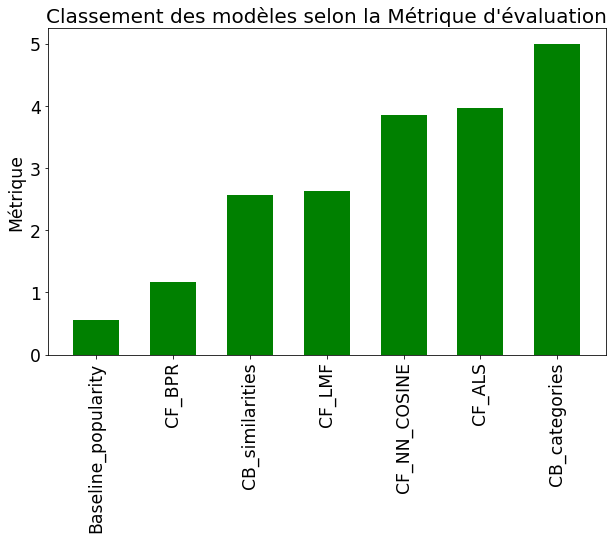

In [85]:
plt.figure(figsize=(10,6))
plt.bar(range(len(dict_results_sorted)), dict_results_sorted.values(), 0.6, color='g')
plt.title("Classement des modèles selon la Métrique d'évaluation", fontsize=20)
plt.xticks(range(len(dict_results_sorted)), dict_results_sorted.keys(), size='xx-large', rotation=90)
plt.ylabel("Métrique", size='xx-large')
plt.yticks(size='xx-large')
plt.show()

## Conclusion :
- **Tous les modèles implémentés sont meilleurs que le modèle simple de référence**
- **Les temps de prédiction sont tous très rapides (réponse quasi immédiate)**
- **Le meilleur modèle est le modèle Content Based basé sur la catégorie des articles**
>**C'est ce modèle que nous allons déployer**